In [1]:
import glob 
import cv2
import numpy as np
import segment2 as seg
from AutoEncoder.ae import CAE
import tensorflow as tf
import os
# deactivate tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

training_data = {
    'frist': (0.05461,0.05525),
    'second': (0.0545,0.05488),
    'third': (0.04927,0.04982),
}

models_files = glob.glob('EvalAEs/*/*.index')
models = [file.replace('.index','') for file in models_files]

aes = []
for model in models:

    ae = CAE(32,(64,64,5),5,True,'small')
    ae.load_weights(model)

    aes.append((model,ae))

pngs = glob.glob('imgs/train_real_world/*/*.png')
jpgs = glob.glob('imgs/train_real_world/*/*.jpg')

files = pngs + jpgs

cce = tf.keras.losses.CategoricalCrossentropy()

fake_features = np.array([[59,59,59],[102,102,102],[178,178,178],[0,255,0],[255,0,0]])
segmentations = []
imgs = []
names = []
for file in files:
    open_cv_image = cv2.imread(file)
    imgs.append(open_cv_image)
    segmentation, _, _, _, _, _, _  = seg.segment3(open_cv_image)


    segmentations.append(segmentation)
    names.append(file)

segmentations = np.array(segmentations)

def pre_2_img(pred):
    pred = (pred @ fake_features).astype(np.uint8)
    pred = cv2.cvtColor(pred,cv2.COLOR_RGB2BGR)
    return pred


for name,ae in aes:
    cces = []
    accuracys = []
    predictions = ae.predict(segmentations)

    for i in range(len(predictions)):
        accuracy = np.sum(np.argmax(segmentations[i],axis=-1) == np.argmax(predictions[i],axis=-1)) / (64*64)
        image_wise = cce(segmentations[i],predictions[i])
        cces.append(image_wise)
        accuracys.append(accuracy)




    cces = np.array(cces)
    min_arg = np.argmin(cces)
    max_arg = np.argmax(cces)

    accuracys = np.array(accuracys)
    
    
    
    #worst = cv2.imread(names[max_arg].replace('train_real_world','train_real_world_segmented'))
    #best = cv2.imread(names[min_arg].replace('train_real_world','train_real_world_segmented'))

    #pred_worst = pre_2_img(predictions[max_arg])
    #pred_best = pre_2_img(predictions[min_arg])


    print(name)
    print('cross entropy',cces.mean(),cces.std(),cces.min(),cces.max())
    print('accuracy',accuracys.mean(),accuracys.std(),accuracys.min(),accuracys.max())

    print(names[min_arg],names[max_arg])
    
    #cv2.imwrite(f'worst-segmenation-{name}.png',worst)
    #cv2.imwrite(f'worst-segmenation-pred-{name}.png',pred_worst)
    #cv2.imwrite(f'best-segmenation-pred-{name}.png',pred_best)
    #cv2.imwrite(f'best-segmenation-{name}.png',best)

2023-08-29 22:09:57.588231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 22:11:07.724806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


5/5 [==============================] - 1s 87ms/step
EvalAEs/Thrid-Trained/ae-20230714-224527
cross entropy 0.16720158 0.124445796 0.0016492058 0.57072335
accuracy 0.9489558293269231 0.0354383527930342 0.815673828125 1.0
imgs/train_real_world/corners/rest12.jpg imgs/train_real_world/rest/42.jpg
5/5 [==============================] - 1s 77ms/step
EvalAEs/First-Trained/ae-20230712-141037
cross entropy 0.15466148 0.114694394 0.0023589926 0.47480217
accuracy 0.9490760216346154 0.03653781326583727 0.835205078125 1.0
imgs/train_real_world/corners/rest12.jpg imgs/train_real_world/rest/52.jpg
5/5 [==============================] - 1s 75ms/step
EvalAEs/Second-Trained/ae-20230713-151838
cross entropy 0.15129037 0.10634673 0.002025648 0.49170798
accuracy 0.9489952674278846 0.03570414066222156 0.83544921875 1.0
imgs/train_real_world/corners/rest12.jpg imgs/train_real_world/rest/42.jpg


In [2]:
name,best = aes[2]

[1, 55, 44, 105, 30]


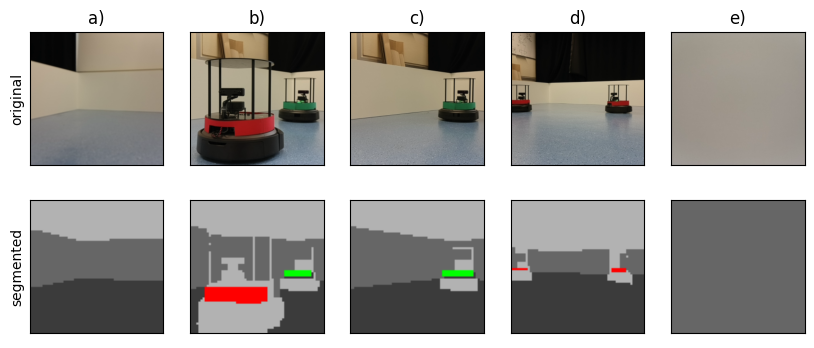

1/1 [==============================] - 0s 48ms/step


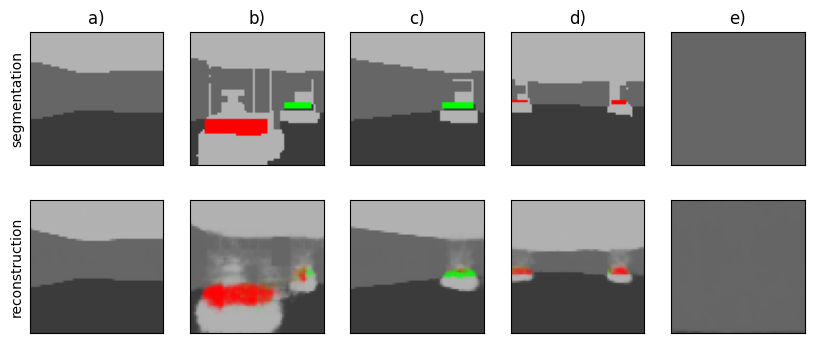

In [3]:
import matplotlib.pyplot as plt
scale = 2
def plot_imgs(shape,imgs):
    global scale

    if shape[0] == 5 or shape[1] == 5:
        scale = 2
    else:
        scale = 2
    plt.figure(figsize=(shape[1] * scale,shape[0] * scale))
    for i,img in enumerate(imgs):
        plt.subplot(shape[0],shape[1],i+1)
        plt.imshow(img)
        #plt.axis('off')
        plt.xticks([])
        plt.yticks([])
    

idxs = [1,55,44,105,30]   #[1,2] 87 55 [102  57] 44 17 51 52 10 




print(idxs)
shape = (2,len(idxs))
segments =  [(seg.segment3(imgs[idx])[0] @ fake_features).astype(np.uint8) for idx in idxs]
plot_imgs(shape,[imgs[idx] for idx in idxs] + segments)

plt.subplot(shape[0],shape[1],1)
plt.ylabel('original')
plt.subplot(shape[0],shape[1],6)
plt.ylabel('segmented')

abc = 'abcdefghijklmnopqrstuvwxyz'
for i in range(0,len(idxs)):
    plt.subplot(shape[0],shape[1],i+1)
    plt.title(abc[i] + ')')
    
plt.show()

predictions = best.predict(np.array([segmentations[idx] for idx in idxs]))
predictions = (predictions @ fake_features).astype(np.uint8)

plot_imgs(shape,np.concatenate([segments,predictions],axis=0))

plt.subplot(shape[0],shape[1],1)
plt.ylabel('segmentation')
plt.subplot(shape[0],shape[1],6)
plt.ylabel('reconstruction')

abc = 'abcdefghijklmnopqrstuvwxyz'
for i in range(0,len(idxs)):
    plt.subplot(shape[0],shape[1],i+1)
    plt.title(abc[i] + ')')


In [4]:
last = 0

def plot_segmented(imgs):
    global last

    shape = (2,len(imgs))
    segments =  [(seg.segment3(img)[0] @ fake_features).astype(np.uint8) for img in imgs]
    plot_imgs(shape,imgs + segments)

    plt.subplot(shape[0],shape[1],1)
    plt.ylabel('original')
    plt.subplot(shape[0],shape[1],shape[1] + 1)
    plt.ylabel('segmented')

    abc = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
    
    for i in range(0,len(imgs)):
        plt.subplot(shape[0],shape[1],i+1)
        plt.title(abc[i + last] + ')')

    last = last + len(imgs)



        
    



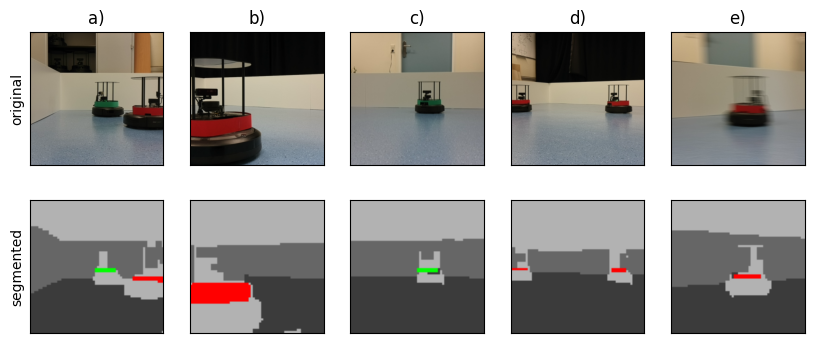

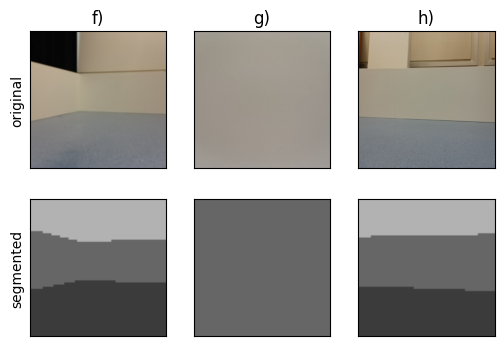

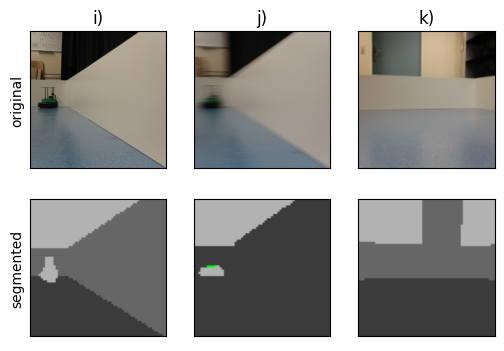

1/1 [==============================] - 0s 54ms/step


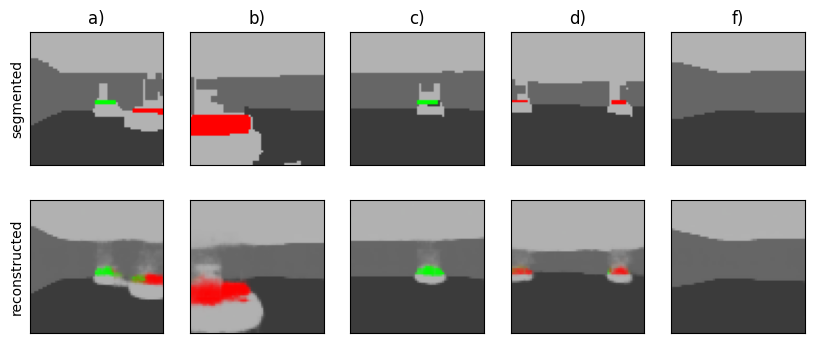

In [5]:
#imgs = np.array(imgs)
#print(imgs.shape)
#
def draw(idxs,filename):
    plot_segmented([imgs[idx] for idx in idxs ])
    plt.savefig(f'imgs/visualisations/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()




last = 0

good_segs = [64,126,112,105,1]

draw([64,126,112,105,90],'robots-good-seg')
draw([1,30,7],'wall-good-seg')
draw([25,12,4],'bad-seg')

segs = [segmentations[idx] for idx in good_segs]
recons = best.predict(np.array(segs))
segs = (segs @ fake_features).astype(np.uint8)
recons = (recons @ fake_features).astype(np.uint8)

plot_imgs(shape,np.concatenate([segs,recons],axis=0))

plt.subplot(shape[0],shape[1],1)
plt.ylabel('segmented')
plt.subplot(shape[0],shape[1],6)
plt.ylabel('reconstructed')

abc = 'abcdfghijklmnopqrstuvwxyz'
for i in range(0,len(good_segs)):
    plt.subplot(shape[0],shape[1],i+1)
    plt.title(abc[i] + ')')

plt.savefig('imgs/visualisations/robots-good-seg-recon.png', dpi=300, bbox_inches='tight')



[4]
[0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 37ms/step
0.81702554


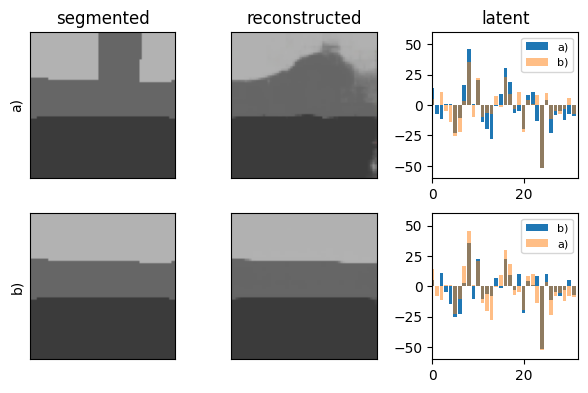

In [6]:
name,best = aes[2]



np.random.seed(3)
idxs = np.random.choice(len(segmentations),5,replace=False)
idxs = [4]
print(idxs)
interesting_segs = segmentations[idxs]
import matplotlib.pyplot as plt

print(interesting_segs[0,0,0])

clean_seg = interesting_segs.copy()
clean_seg[:,0:21,20:64] = [0, 0, 1, 0, 0]

clean_seg[:,:,:,4] = clean_seg[:,:,:,3] + clean_seg[:,:,:,4]
clean_seg[:,:,:,3] = 0

interesting_segs = np.concatenate([interesting_segs,clean_seg],axis=0)

fig = plt.figure(figsize=(2 * 3, 2  * len(interesting_segs)))
abc = ['a)','b)']
i = 0

latents = best.encode(np.array(interesting_segs))

for seg in interesting_segs:
    
    #plt.subplot(len(interesting_segs),4,i)
    #plt.title('original')
    #plt.xticks([])
    #plt.yticks([])
    #img = imgs[idxs[i-1]]
    #img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    #plt.imshow(img)



    plt.subplot(len(interesting_segs),3,i * 3 + 1)
    plt.ylabel(abc[i] )#)+ ')')
    plt.xticks([])
    plt.yticks([])
    img = pre_2_img(seg)
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    if i == 0:
        plt.title('segmented')

    pred = best.predict(np.array([seg]))[0]
    plt.subplot(len(interesting_segs),3,i * 3 +2)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title('reconstructed')
    
    pred = pre_2_img(pred)
    pred = cv2.cvtColor(pred,cv2.COLOR_RGB2BGR)
    plt.imshow(pred)

    latent = latents[i].numpy()
    plt.subplot(len(interesting_segs),3,i*3 + 3)
    if i == 0:
        plt.title('latent')

    arr = ['a)','b)']
    
    plt.bar(range(len(latent)),latent,label=arr[i])
    diff = (latents[(i+1)%2]).numpy()

    
    plt.bar(range(len(diff)),diff,alpha=0.5,label=arr[(i+1)%2])
    plt.legend(
        loc='upper right',
        prop={'size': 8}
    )


    plt.xlim(0,len(latent))
    plt.ylim(-60,60)
    # set aspect ratio
    ax = plt.gca()
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')


    i += 1

cos_sim = np.dot(latents[0],latents[1]) / (np.linalg.norm(latents[0]) * np.linalg.norm(latents[1]))
print(cos_sim)

plt.tight_layout()

plt.savefig('imgs/visualisations/bad-recon.png', dpi=300, bbox_inches='tight')
plt.show()





1/1 [==============================] - 0s 53ms/step
55.655422
28.651566
tf.Tensor(0.8899654, shape=(), dtype=float32)
tf.Tensor(0.9713876, shape=(), dtype=float32)


<AxesSubplot:>

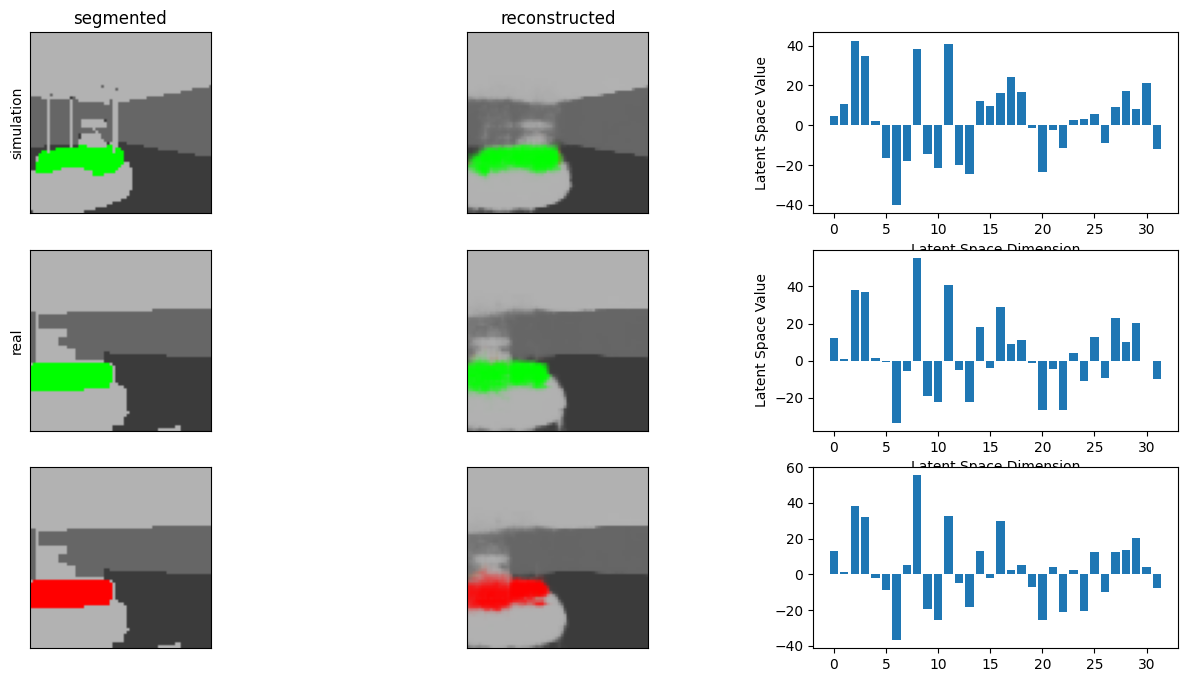

In [7]:
import domain_randomization as dr

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


sim_img = cv2.imread('imgs/compare_latentspace/25-sim.png')
real_img = cv2.imread('imgs/compare_latentspace/25.png')
real_img = cv2.cvtColor(real_img,cv2.COLOR_BGR2RGB)
real_red_img = real_img.copy()
real_reds = real_img[:,:,0].copy()
real_img[:,:,0] = real_img[:,:,1]
real_img[:,:,1] = real_reds 

min_w_h = min(sim_img.shape[0],sim_img.shape[1])
sim_img = sim_img[:min_w_h,:min_w_h,:]
#sim_img = cv2.resize(sim_img,(64,64),interpolation=cv2.INTER_NEAREST)

sim_seg  = dr.segment(sim_img)
real_seg = dr.segment(real_img)
real_red_seg = dr.segment(real_red_img)

sim_seg_img = (sim_seg @ fake_features).astype(np.uint8)
real_seg_img = (real_seg @ fake_features).astype(np.uint8)
real_red_seg_img = (real_red_seg @ fake_features).astype(np.uint8)

predictions = best.predict(np.array([sim_seg,real_seg,real_red_seg]))


real_pre_img = (predictions[1] @ fake_features).astype(np.uint8)
sim_pre_img = (predictions[0] @ fake_features).astype(np.uint8)
real_red_pre_img = (predictions[2] @ fake_features).astype(np.uint8)

figs = (3,3)

plt.figure(figsize=(4*4,2*4))

plt.subplot(figs[0],figs[1],1)
plt.ylabel('simulation')
plt.title('segmented')
plt.imshow(sim_seg_img)
plt.xticks([])
plt.yticks([])
plt.subplot(figs[0],figs[1],4)
plt.ylabel('real')
plt.imshow(real_seg_img)
plt.xticks([])
plt.yticks([])


plt.subplot(figs[0],figs[1],2)
plt.title('reconstructed')
plt.imshow(sim_pre_img)
plt.xticks([])
plt.yticks([])

plt.subplot(figs[0],figs[1],5)

plt.imshow(real_pre_img)
plt.xticks([])
plt.yticks([])




latents = best.encode(np.array([sim_seg,real_seg,real_red_seg]))

plt.subplot(figs[0],figs[1],3)
plt.bar(range(32),latents[0])
plt.subplot(figs[0],figs[1],6)
plt.bar(range(32),latents[1])

diff = (latents[0] - latents[1])
diff_red = (latents[1] - latents[2])

print( np.linalg.norm(diff))
print( np.linalg.norm(diff_red))

cosine_dist_1 = latents[0] @ latents[1] / (np.linalg.norm(latents[0]) * np.linalg.norm(latents[1]))
cosine_dist_2 = latents[1] @ latents[2] / (np.linalg.norm(latents[1]) * np.linalg.norm(latents[2]))

print(cosine_dist_1)
print(cosine_dist_2)


plt.subplot(figs[0],figs[1],3)
plt.ylabel('Latent Space Value')
#plt.bar(range(32),-diff)
plt.xlabel('Latent Space Dimension')
plt.subplot(figs[0],figs[1],6)
#plt.bar(range(32),diff)
plt.ylabel('Latent Space Value')
plt.xlabel('Latent Space Dimension')

plt.subplot(figs[0],figs[1],7)
plt.imshow(real_red_seg_img)
plt.xticks([])
plt.yticks([])
plt.subplot(figs[0],figs[1],8)
plt.imshow(real_red_pre_img)
plt.xticks([])
plt.yticks([])
plt.subplot(figs[0],figs[1],9)
plt.bar(range(32),latents[2])
plt.subplot(figs[0],figs[1],9)





0.97138774


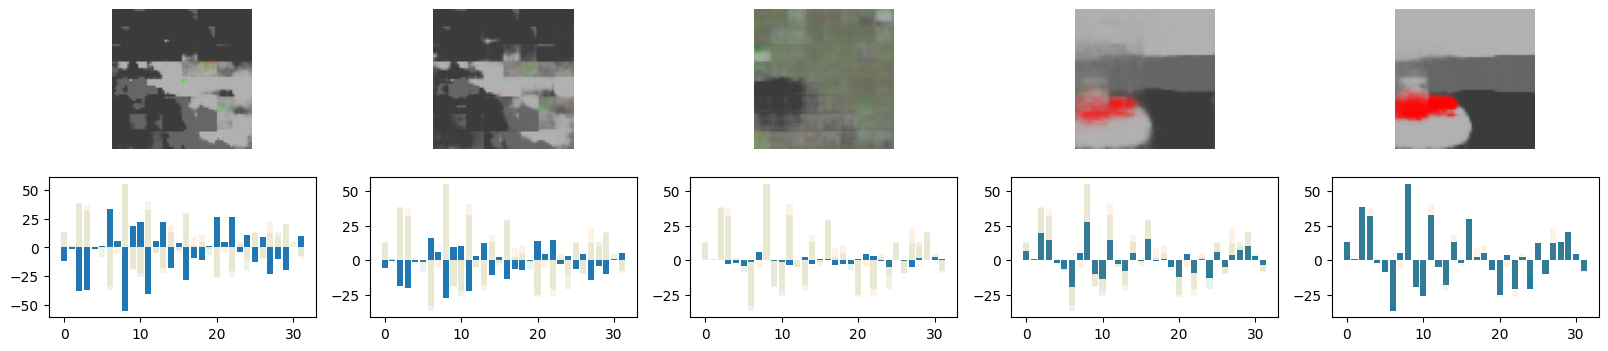

In [8]:
interpolate = np.array([latents[1]* (-1)  * (1-x) + latents[2] * x for x in np.linspace(0,1,5)])

interpolation = best.decode(interpolate)

plt.figure(figsize=(20,4))
dif = np.abs(interpolation[0] - interpolation[1])

i = 0
for inter in interpolation:
    i += 1
    plt.subplot(2,5,i)
    img = (inter.numpy() @ fake_features).astype(np.uint8)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(2,5,i+5)
    pl = interpolate[i-1]
    #print(inter.numpy().shape)
    plt.bar(range(32),pl)
    plt.bar(range(32),latents[1],alpha=0.1)
    plt.bar(range(32),latents[2],alpha=0.1)

fake_space = np.zeros((32,))

cos_sim_interest = np.dot(latents[1],latents[2]) / (np.linalg.norm(latents[1]) * np.linalg.norm(latents[2]))
print(cos_sim_interest)

In [9]:
# backward pass to get input of latent space



In [10]:
all_latents = best.encode(segmentations)

In [11]:
normalized_latents = all_latents / np.linalg.norm(all_latents, axis=1)[:, np.newaxis]

cosine_distances = np.array([np.dot(normalized_latents, normalized_latents[i]) for i in range(len(normalized_latents))])

cosine_distances.mean()

0.46929362

(130, 130)
(81, 118)


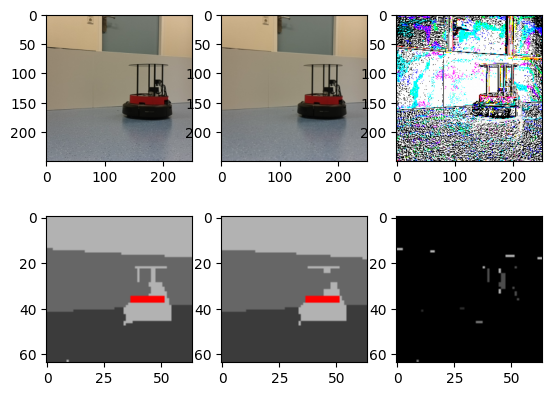

In [12]:


cosine_distances += np.eye(len(cosine_distances)) * -2

def pair(arr):
    return np.array([[a,b] for a in arr for b in arr])

def combine(arr):
    return np.concatenate([pair(a) for a in arr])

cosine_distances

a = [8, 10,30,35,36]
b = [91, 126]
c = [40, 43]
d = [4,5]
f = [58, 107, 75,104,103]
e = [106, 124]
g = [39, 44]

# not same but segmentation problem:
h = [37, 8]
l = [23, 29]
s = [41, 115]
q = [53, 54]
x = [71, 104]
y = [22, 27]
z = [96, 105]
m = [21, 38]
n = [66, 91]

exludes = combine([a,b,c,d,f,e,g,h,l,s,q,x,y,z,m,n])

#print(exludes)
cosine_distances[exludes] = -1

# find min similarity pair
print(cosine_distances.shape)
min_arg = np.argmax(cosine_distances)

min_pair = np.unravel_index(min_arg, cosine_distances.shape)

print(min_pair)

plt.subplot(2,3,1)
plt.imshow(imgs[min_pair[0]])
plt.subplot(2,3,2)
plt.imshow(imgs[min_pair[1]])
plt.subplot(2,3,3)
plt.imshow(imgs[min_pair[0]]-imgs[min_pair[1]])
plt.subplot(2,3,4)
seg = (segmentations[min_pair[0]] @ fake_features).astype(np.uint8)
plt.imshow(seg)
plt.subplot(2,3,5)
seg = (segmentations[min_pair[1]] @ fake_features).astype(np.uint8)
plt.imshow(seg)
plt.subplot(2,3,6)
seg = (segmentations[min_pair[0]] @ fake_features).astype(np.uint8) - (segmentations[min_pair[1]] @ fake_features).astype(np.uint8)
plt.imshow(seg)
plt.show()


0.9920912
0.9969013
0.99508214


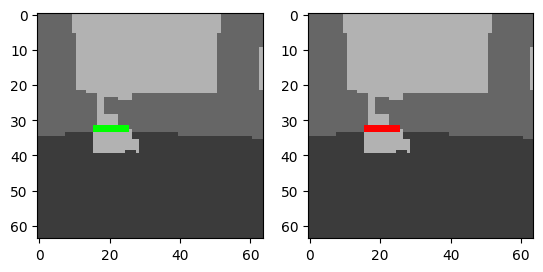


(91,)
17
1
0.9751405
0.999868


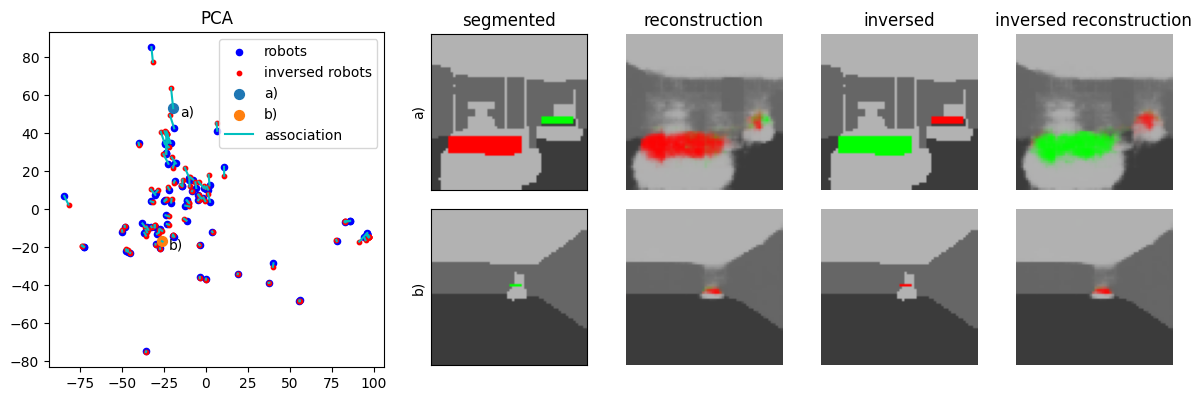

In [18]:
latents_all = best.encode(segmentations).numpy()
invers = segmentations.copy()
tmp = segmentations[:, :, :,4]
invers[:, :, :, 4] = segmentations[:, :, :, 3]
invers[:, :, :, 3] = tmp

only_red = segmentations.copy()
only_red[:, :, :, 4] = segmentations[:, :, :, 3] + segmentations[:, :, :, 4]
only_red[:, :, :, 3] = 0

only_blue = segmentations.copy()
only_blue[:, :, :, 3] = segmentations[:, :, :, 3] + segmentations[:, :, :, 4]
only_blue[:, :, :, 4] = 0


latents_invers = best.encode(invers).numpy()
latents_only_red = best.encode(only_red).numpy()
latents_only_blue = best.encode(only_blue).numpy()



selected = np.logical_or(segmentations[:,:,:,4] == 1, segmentations[:,:,:,3] == 1)
selected = selected.any(axis=1).any(axis=1)
selected = np.argwhere(selected)

latents_all_all = latents_all.copy().reshape(-1, 32)
latents_all = latents_all[selected].reshape(-1, 32)
#print(latents_all.shape)
latents_invers = latents_invers[selected].reshape(-1, 32)

latents_only_red = latents_only_red[selected].reshape(-1, 32)
latents_only_blue = latents_only_blue[selected].reshape(-1, 32)


#print(selected) 

cos_sim = (latents_all * latents_invers).sum(axis=1) / (np.linalg.norm(latents_all, axis=1) * np.linalg.norm(latents_invers, axis=1))
cos_sim_red = (latents_all * latents_only_red).sum(axis=1) / (np.linalg.norm(latents_all, axis=1) * np.linalg.norm(latents_only_red, axis=1))
cos_sim_blue = (latents_all * latents_only_blue).sum(axis=1) / (np.linalg.norm(latents_all, axis=1) * np.linalg.norm(latents_only_blue, axis=1))

#cos_sim 

print(cos_sim.mean())
print(cos_sim_red.mean())
print(cos_sim_blue.mean())



plt.subplot(1, 2, 1)
plt.imshow((segmentations[100, :, :, :] @ fake_features).astype(np.uint8))
plt.subplot(1, 2, 2)
plt.imshow((invers[100, :, :, :] @ fake_features).astype(np.uint8))
plt.show()
# run pca on latents 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca.fit(np.concatenate([latents_all_all,latents_all, latents_invers], axis=0))


#print(selected)

#print(latents_all.shape)

pca_all_all = pca.transform(latents_all_all)
pca_all = pca.transform(latents_all)
pca_invers = pca.transform(latents_invers)
pca_only_red = pca.transform(latents_only_red)
pca_only_blue = pca.transform(latents_only_blue)

# inverse pca 


print()

#color = np.random.rand((len(pca_all)))
fig = plt.figure(figsize=(2 * 6, 2 * 2))
#fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.tight_layout(  )

grid = (2, 6)
bigax = plt.subplot2grid(grid, (0, 0), colspan=2,rowspan=2)

bigax.set_title('PCA')
#bigax.scatter(pca_all_all[:, 0], pca_all_all[:, 1], c='k',s=5, cmap='viridis')

bigax.scatter(pca_all[:, 0], pca_all[:, 1], c='b',s=20, cmap='viridis')
bigax.scatter(pca_invers[:, 0], pca_invers[:, 1], c='r',s=10, cmap='viridis')

#plt.scatter(pca_only_red[:, 0], pca_only_red[:, 1], c='g',s=5, cmap='viridis')
#plt.scatter(pca_only_blue[:, 0], pca_only_blue[:, 1], c='y',s=3, cmap='viridis')

spetial = np.argsort(cos_sim)
print(spetial.shape)
spetial = np.concatenate([[17],spetial[-2:-1]])

c = 0
abc = 'abc'
for i in spetial:
    print(i)
    bigax.scatter(pca_all[i, 0], pca_all[i, 1],s=50, alpha=1)
    x,y = pca_all[i, 0], pca_all[i, 1]
    bigax.annotate(abc[c] + ')', (x + 4 ,y - 4 ),c='black', fontsize=10)
    c += 1




for i in range(0, len(pca_all), 1):
    bigax.plot([pca_all[i, 0], pca_invers[i, 0]], [pca_all[i, 1], pca_invers[i, 1]], c='c', alpha=1)
    x,y = pca_all[i, 0], pca_all[i, 1]
    
    #bigax.annotate(str(i) + ')', (x - 8 ,y + 2 ), fontsize=10)    

bigax.legend(['robots', 'inversed robots','a)','b)','association'], loc='upper right')
    #
#plt.colorbar()



    

bigax.set_aspect(1 / bigax.get_data_ratio(),adjustable='box')

#plt.show()

#plt.figure(figsize=(len(spetial) * 5,2 * 5))
abc = 'abc'
for i in range(len(spetial)):


    ax = plt.subplot2grid(grid,(i, 2), colspan=1,rowspan=1)
    plt.ylabel(abc[i] + ')')
    arr = spetial[i]
    #print(arr)
    idx = selected[arr][0]
    img = (segmentations[idx] @ fake_features).astype(np.uint8)
    
    if i == 0:
        plt.title('segmented')

    
    print(cos_sim[arr])
    ax.imshow(img)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    #ax.axis('off')
    ax.set_aspect(1 / ax.get_data_ratio(),adjustable='box')
    

    ax = plt.subplot2grid(grid,(i, 3), colspan=1,rowspan=1)
    if i == 0:
        plt.title('reconstruction')
    
    recon = best.decode(latents_all[arr].reshape(1, 32)).numpy().reshape(64, 64, 5)
    ax.imshow((recon @ fake_features).astype(np.uint8))
    ax.axis('off')
    ax.set_aspect(1 / ax.get_data_ratio(),adjustable='box')

    ax = plt.subplot2grid(grid,(i, 4), colspan=1,rowspan=1)
    if i == 0:
        plt.title('inversed')
    #recon = best.decode(latents_all[arr].reshape(1, 32)).numpy().reshape(64, 64, 5)
    ax.imshow((invers[idx] @ fake_features).astype(np.uint8))
    ax.axis('off')

    ax.set_aspect(1 / ax.get_data_ratio(),adjustable='box')

   
    

    ax = plt.subplot2grid(grid,(i, 5), colspan=1,rowspan=1)
    if i == 0:
        plt.title('inversed reconstruction')
    
    recon = best.decode(latents_invers[arr].reshape(1, 32)).numpy().reshape(64, 64, 5)
    ax.imshow((recon @ fake_features).astype(np.uint8))
    ax.set_aspect(1 / ax.get_data_ratio(),adjustable='box')
    ax.axis('off')

plt.tight_layout()


plt.savefig('imgs/visualisations/color-blind.png', dpi=300, bbox_inches='tight')
plt.show()


(2, 64, 64, 5)
1/1 [==============================] - 0s 135ms/step
0.98318166


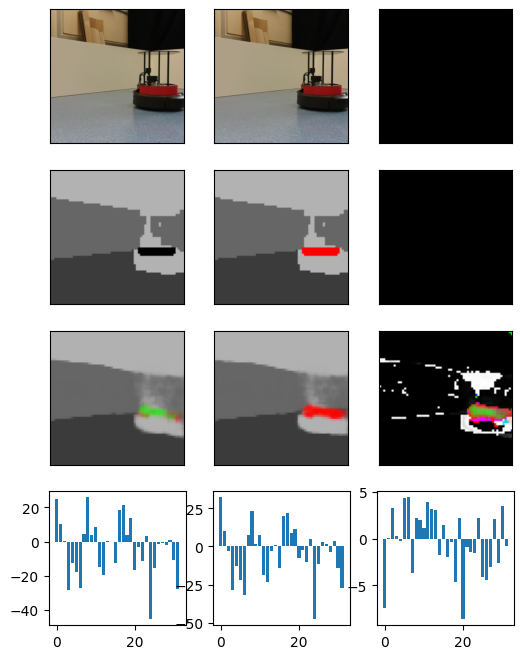

In [14]:
idxs = [48,48]

segms = (segmentations[idxs])

segms[0,:,:,4] = segms[0,:,:,3].copy()
segms[0,:,:,3] = 0
print(segms.shape)

recon = (best.predict(segms) @ fake_features).astype(np.uint8)

laten_s = best.encode(segms)
segms = (segms @ fake_features).astype(np.uint8)


plot_imgs((4,3),[imgs[idxs[0]],imgs[idxs[1]],np.abs(imgs[idxs[0]] - imgs[idxs[1]])] + [segms[0],segms[1],np.abs(segms[0] - segms[1])] + [recon[0],recon[1],np.abs(recon[0] - recon[1])])

plt.subplot(4,3,10)
plt.bar(range(0,laten_s.shape[1]),laten_s[0])
plt.subplot(4,3,11)
plt.bar(range(0,laten_s.shape[1]),laten_s[1])
plt.subplot(4,3,12)
plt.bar(range(0,laten_s.shape[1]),(laten_s[0] - laten_s[1]))


cos_sim = np.dot(laten_s[0],laten_s[1])/(np.linalg.norm(laten_s[0])*np.linalg.norm(laten_s[1]))
print(cos_sim)

[102 102 102]
0.95079064


<Figure size 1000x1000 with 0 Axes>

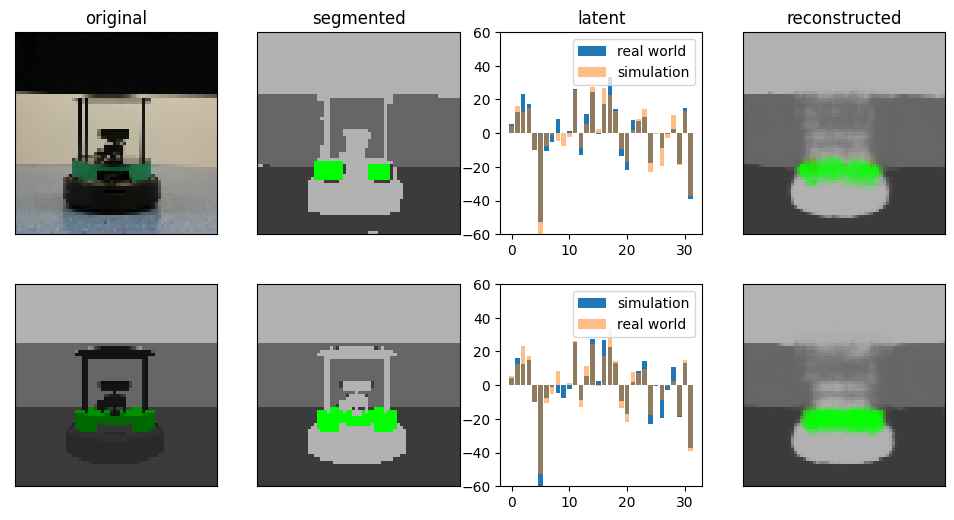

In [15]:
import segment2 as seg

real_world = cv2.imread('imgs/train_real_world/record-000101.png')
sim = cv2.resize(cv2.imread('imgs/train_real_world/img_1_1692460218.7292702.png'),(55,64))

background = [178,178,178]
background2 = [176,176,176]

wall = [102,102,102]

stripe = sim[:,0]
new_sim = np.zeros((64,64,3),np.uint8)

new_sim[:,:] = stripe[:,np.newaxis]

new_sim[:,4:59] = sim

new_sim[19:30,:] = np.where(new_sim == background,wall,new_sim)[19:30,:]
new_sim[19:30,:] = np.where(new_sim == background2,wall,new_sim)[19:30,:]


sim = new_sim

print(sim[23,0])

plt.figure(figsize=(10, 10))

#sim  = np.where(sim == [0,104,0],[1,144,1],sim)

imgs = [real_world, sim]




shape = (2,4)
latents = []
plt.figure(figsize=(shape[1] * 3, shape[0] * 3))
for i in range(2):
    plt.subplot(shape[0], shape[1], i * shape[1] +1)
    if i == 0:
        plt.title('original')
    plt.xticks([])
    plt.yticks([])
    segm = None
    if i == 0:
        segm = seg.segment3(imgs[i])[0]
    elif i == 1:
        segm = dr.segment(imgs[i])

    plt.imshow(cv2.resize(imgs[i],(64,64)))
    plt.subplot(shape[0], shape[1], i * shape[1]  +2)
    if i == 0:
        plt.title('segmented')
    plt.xticks([])
    plt.yticks([])
    #segm = (segm @ fake_features).astype(np.uint8)
    plt.imshow((segm  @ fake_features).astype(np.uint8))

    plt.subplot(shape[0], shape[1], i * shape[1]  +3)
    lentent = best.encoder(segm[np.newaxis,:,:,:])[0]
    latents.append(lentent)
    plt.bar(range(32),lentent)
    if i == 0:
        plt.title('latent')
    ax = plt.gca()
    plt.ylim(-60,60)
    ax.set_aspect(1 / ax.get_data_ratio(), adjustable='box')


    recon = best.decoder(lentent[np.newaxis,:])[0]
    plt.subplot(shape[0], shape[1], i * shape[1]  +4)
    plt.imshow((recon  @ fake_features).astype(np.uint8))
    if i == 0:
        plt.title('reconstructed')

    plt.xticks([])
    plt.yticks([])


cos_sim = np.dot(latents[0],latents[1]) / (np.linalg.norm(latents[0]) * np.linalg.norm(latents[1]))
print(cos_sim)

other = ['real world','simulation']

for i in range(2):

    plt.subplot(shape[0], shape[1], i * shape[1]  +3)
    diff = latents[(i +1) % 2]

    plt.bar(range(32),diff,alpha=0.5)

    plt.legend(other)

    # shift to the right
    other = [other[-1]] + other[:-1]
    

    

plt.savefig('imgs/visualisations/sim-real-comparision.png', dpi=300, bbox_inches='tight')
plt.show()




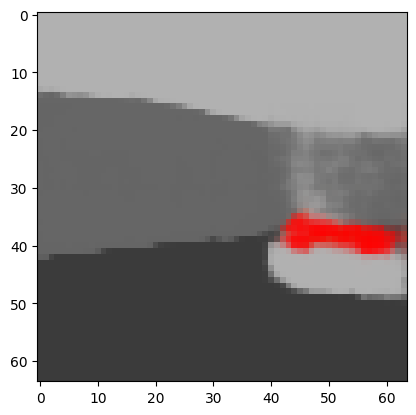

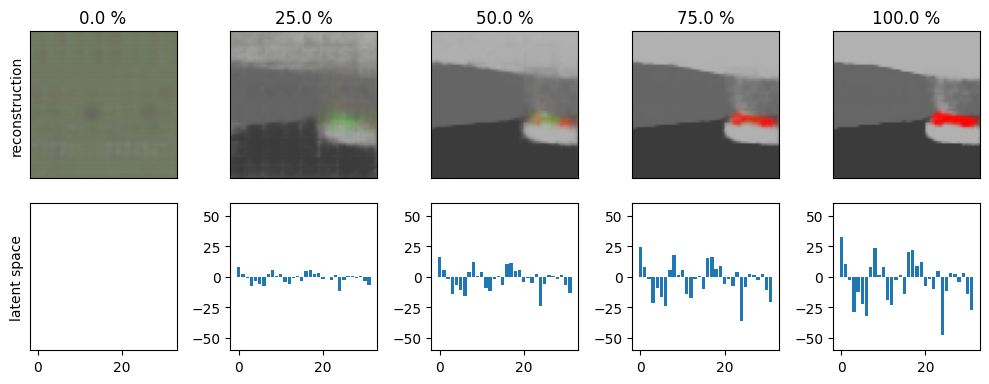

In [16]:
decod = (best.decode(laten_s[1].reshape(1,32)) @ fake_features).astype(np.uint8)

mask = np.zeros((32,))
mask[:20] = 1


plt.imshow(decod[0,:,:,:])

interpolation = np.linspace(0,1,5)
random_chang = np.random.uniform(-0.1,0.1,32) * 0
plt.figure(figsize=(5*2,2*2))
for i in range(5):

    

    latent = interpolation[i] * laten_s[1] + random_chang
    
    decod = (best.decode(latent.reshape(1,32)) @ fake_features).astype(np.uint8)
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{interpolation[i] * 100} %")
    plt.imshow(decod[0,:,:,:])
    plt.subplot(2,5,i+6)
    plt.bar(np.arange(32),latent)
    plt.ylim(-60,60)
        
    #aspect ratio

    ax = plt.gca()
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    
plt.subplot(2,5,1)
plt.ylabel("reconstruction")
plt.subplot(2,5,6)
plt.ylabel("latent space")
plt.yticks([])


plt.tight_layout()
plt.savefig('imgs/visualisations/interpolation.png', dpi=300, bbox_inches='tight')
plt.show()


IndexError: list index out of range

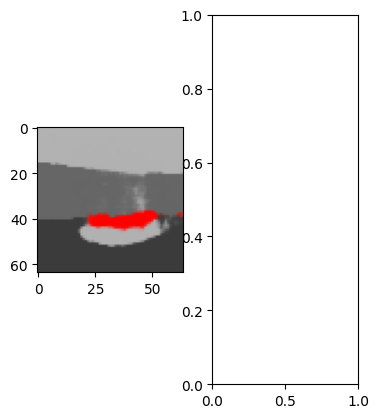

In [17]:
result = latents[1].numpy() * 1 + laten_s[1] 

#latents[0] - laten_s[1]

decod = best.decode(result.reshape(1,32))

plt.subplot(1,3,1)
plt.imshow((decod @ fake_features).astype(np.uint8).reshape(64,64,3))
plt.subplot(1,3,2)
decod_latn = best.decode(latents[2].numpy().reshape(1,32))
plt.imshow((decod_latn @ fake_features).astype(np.uint8).reshape(64,64,3))
plt.subplot(1,3,3)
plt.bar(range(0,32),result,alpha=0.2)
plt.bar(range(0,32),latents[2],alpha=0.2)

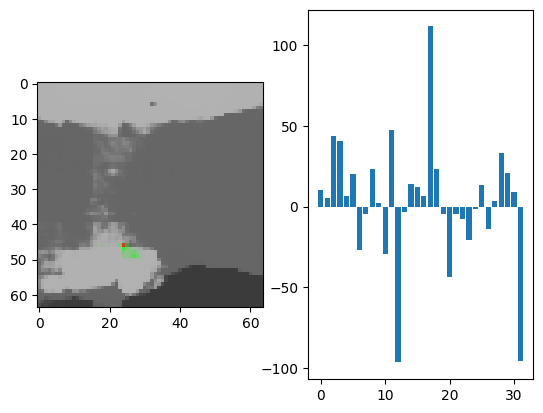

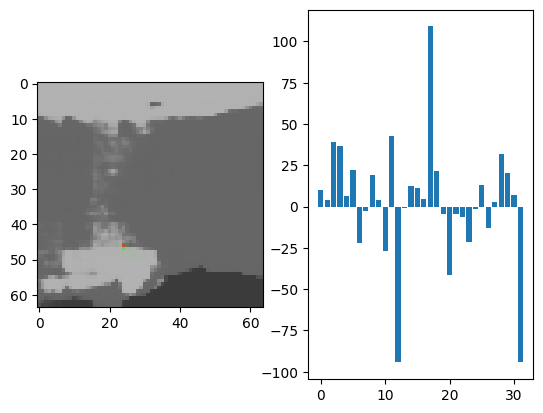

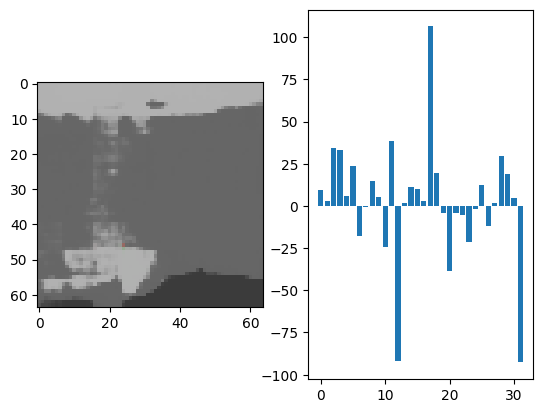

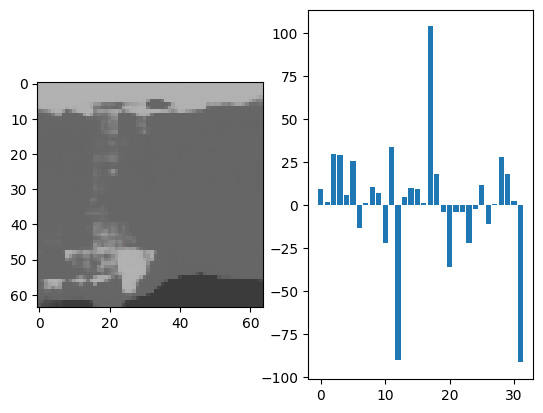

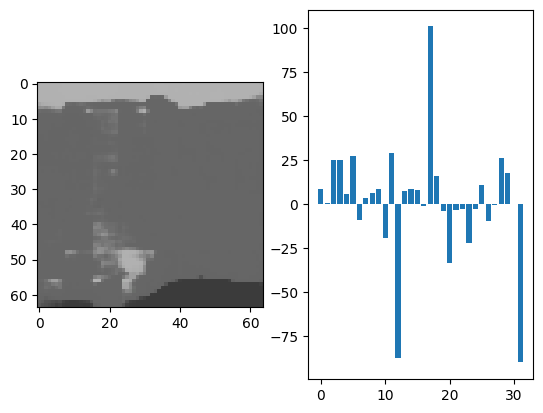

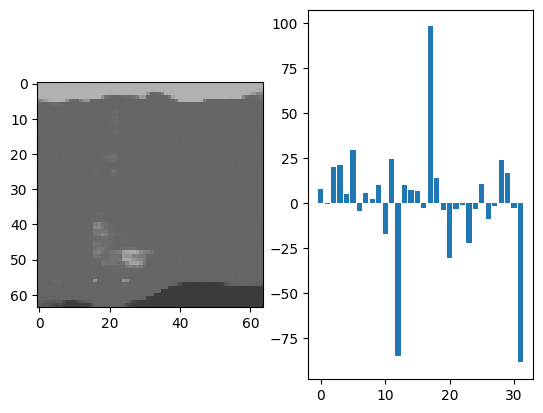

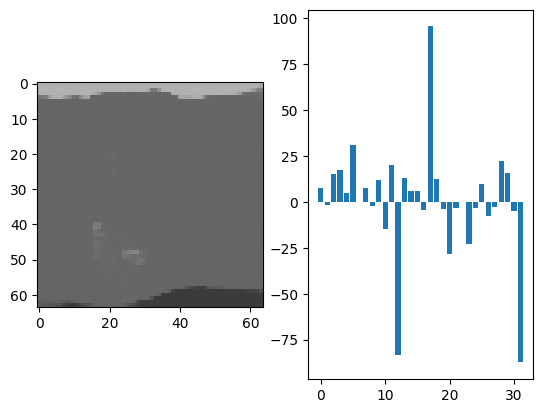

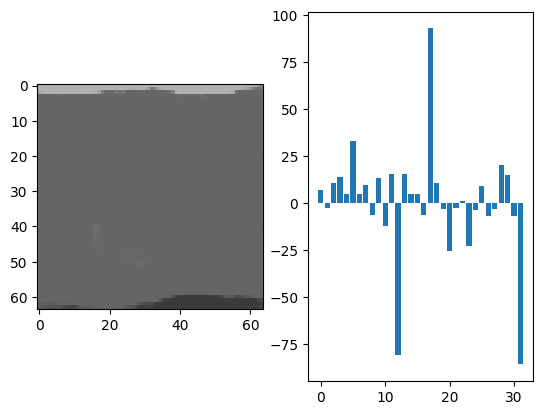

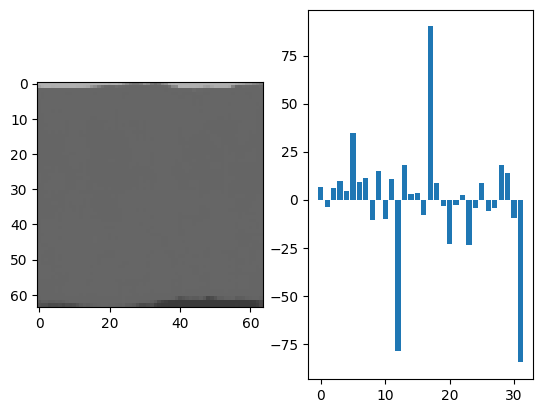

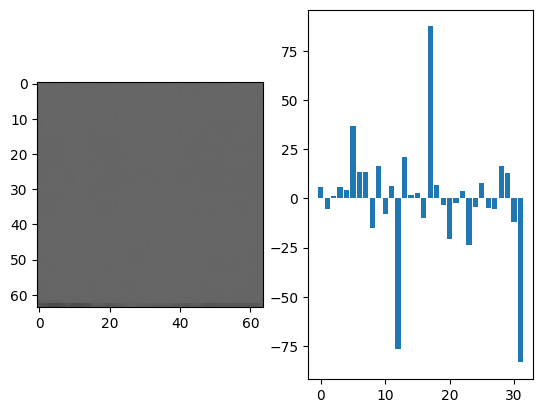

In [ ]:
# interpolation begin with linspace
ts = np.linspace(0,1,10)

interplatio_b = [(latents[0] + laten_s[0]) * (1-t) + laten_s[0]  * t for t in ts]

interplatio_b = np.array(interplatio_b)
decodedI = best.decode(interplatio_b)
decodedI = (decodedI @ fake_features).astype(np.uint8)
i = 0
for img in decodedI:
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.bar(range(0,32),interplatio_b[i])
    plt.show()
    i += 1



In [ ]:
np.linalg.norm(latents[0] - latents[1])

55.655422

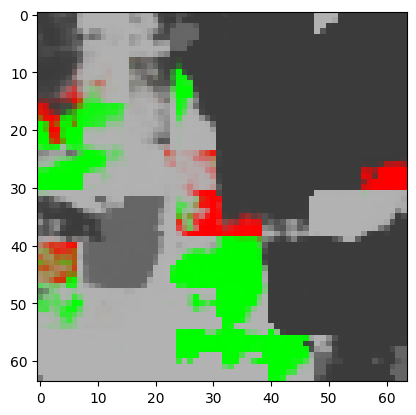

In [ ]:

selected = [6,7,8,9,10,11,12,13]

np.random.seed(0)
fake_space = np.random.normal(size=(1,32)) * 100



#fake_space[selected] = latents[1][selected] * 10000
#fake_space[selected] += latents[3][selected] * 0.5
plt.figure()
next_ = best.decode(fake_space.reshape(1,32))
next_ = (next_.numpy() @ fake_features).astype(np.uint8)
plt.imshow(next_[0])
